In [1]:
# !pip install spacy
# !python -m spacy download en

In [2]:
import spacy
spacy.load('en_core_web_sm')

In [3]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
import torch
from torchtext import data

text_field = data.Field(tokenize = 'spacy', batch_first = True)

label_field = data.LabelField(dtype = torch.float)

# Loading the training dataset.
train_dataset = data.TabularDataset(
path='../data/HW5_training.csv', format='csv', skip_header=True,
fields=[('text', text_field),
        ('label', label_field)])

# Loading the testing dataset.
test_data = data.TabularDataset(
path='../data/HW5_test.csv', format='csv', skip_header=True,
fields=[('text', text_field),
        ('label', label_field)])

# Splitting the training data into 80% train and 20% validation sets.
train_data, valid_data = train_dataset.split(split_ratio=0.8)

# Building the vocabulary for the labels
label_field.build_vocab(train_data)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 80
Number of validation examples: 20
Number of testing examples: 20


In [5]:
# Defining the batch size.
batch_size = 64

# Iterators for the training, validation and test sets.
train_iterator = data.BucketIterator(train_data, batch_size = batch_size)
valid_iterator = data.BucketIterator(valid_data, batch_size = batch_size)
test_iterator = data.BucketIterator(test_data, batch_size = batch_size)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim))
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [7]:
MAX_VOCAB_SIZE = 25_000

text_field.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [8]:
INPUT_DIM = len(text_field.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = text_field.vocab.stoi[text_field.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 191,501 trainable parameters


In [10]:
pretrained_embeddings = text_field.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.7518,  0.5508,  1.9979,  ..., -1.3246,  1.0345, -0.4162],
        [ 1.5745,  0.8015,  0.4579,  ..., -1.1444, -0.1901, -0.0159],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        ...,
        [ 2.0388,  0.7615,  0.4977,  ..., -0.2734,  1.2468,  0.8784],
        [-0.5718,  0.0463,  0.8673,  ..., -0.3566,  0.9293,  0.8995],
        [ 0.1238,  0.0467,  0.1646,  ..., -0.1151,  0.2209, -0.4480]])

In [11]:
UNK_IDX = text_field.vocab.stoi[text_field.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [12]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

In [13]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [14]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [15]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [17]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses_lst = []
valid_losses_lst = []

# Auditing the start time.
start_time_total = time.time()

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn-model-small.pt')
        
    train_losses_lst.append(train_loss)
    valid_losses_lst.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
# Auditing the start time.
time_taken_total = time.time() - start_time_total
print("Training Time :: ", time_taken_total)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.683 | Train Acc: 60.16%
	 Val. Loss: 0.690 |  Val. Acc: 55.00%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.622 | Train Acc: 58.59%
	 Val. Loss: 0.687 |  Val. Acc: 60.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.558 | Train Acc: 83.59%
	 Val. Loss: 0.681 |  Val. Acc: 60.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.479 | Train Acc: 87.50%
	 Val. Loss: 0.675 |  Val. Acc: 60.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.532 | Train Acc: 82.03%
	 Val. Loss: 0.673 |  Val. Acc: 60.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.515 | Train Acc: 80.47%
	 Val. Loss: 0.670 |  Val. Acc: 50.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.430 | Train Acc: 88.28%
	 Val. Loss: 0.667 |  Val. Acc: 60.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.392 | Train Acc: 92.97%
	 Val. Loss: 0.664 |  Val. Acc: 60.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.413 | Train Acc: 95.31%
	 Val. Loss: 0.664 |  Val. Acc: 55.00%
Epoch: 10 | Epoch Time: 0m 0

In [18]:
model.load_state_dict(torch.load('cnn-model-small.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.729 | Test Acc: 60.00%


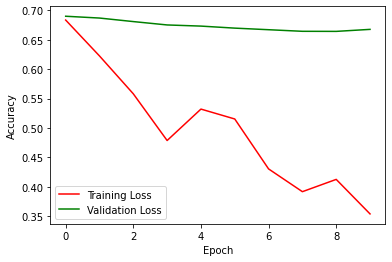

<Figure size 432x288 with 0 Axes>

In [19]:
# Plotting the learning curves.
import matplotlib.pyplot as plt

plt.plot(train_losses_lst, 'r', label="Training Loss")
plt.plot(valid_losses_lst, 'g', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('CNN-Large.png')

In [20]:
def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    
    # Converting the output into a predicted class (0 or 1).
    prediction = torch.round(prediction.squeeze())
    
    return prediction.item()

In [21]:
predict_sentiment(model, "This is a word!")

1.0

In [22]:
import pandas as pd
import numpy as np

# Loading the training dataset.
train_data_input = pd.read_csv("../data/HW5_training.csv")
train_data_input = train_data_input.reindex(np.random.permutation(train_data_input.index)) # Shuffling the data.

# Loading the testing dataset.
test_data_input = pd.read_csv("../data/HW5_test.csv")

# Sample text and its label.
train_data_input[:5]

,Text,Label
54,"Oh, okay. #uhh# Well I don't do anything you k...",0
16,"No, no we're in #uh# Morristown Tennesee, fift...",1
58,Well we do all I mean we will rent a truck whe...,0
77,Nope I am all set with Premier---,0
80,"Actually, do you have an #uhh# the ability to ...",0


In [23]:
# Defining the function for getting the confusion matrix.
def confusion(prediction, truth):
    confusion_vector = prediction / truth
    
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [24]:
# Obtaining the confusion matrix for the training dataset.
prediction_lst = []
for text, label in zip(train_data_input["Text"], train_data_input["Label"]):
    prediction_lst.append(predict_sentiment(model, text))
    
true_positives, false_positives, true_negatives, false_negatives = confusion(
    torch.Tensor(prediction_lst), torch.tensor(train_data_input["Label"].to_numpy()))

accuracy = (true_positives + true_negatives)/len(prediction_lst)
print("Accuracy :: ", accuracy)
print("Confusion Matrix :: \n", true_positives, "\t", false_positives, "\n", false_negatives, "\t", true_negatives)

Accuracy ::  0.91
Confusion Matrix :: 
 45 	 4 
 5 	 46


In [25]:
# Obtaining the confusion matrix for the testing dataset.
prediction_lst = []
for text, label in zip(test_data_input["Text"], test_data_input["Label"]):
    prediction_lst.append(predict_sentiment(model, text))

true_positives, false_positives, true_negatives, false_negatives = confusion(
    torch.Tensor(prediction_lst), torch.Tensor(test_data_input["Label"].to_numpy()))
accuracy = (true_positives + true_negatives)/len(prediction_lst)

print("Accuracy :: ", accuracy)
print("Confusion Matrix :: \n", true_positives, "\t", false_positives, "\n", false_negatives, "\t", true_negatives)

Accuracy ::  0.6
Confusion Matrix :: 
 8 	 6 
 2 	 4
